In [185]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, roc_curve, auc
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import shap
from keras.layers import Input, Dense, Flatten, \
    Concatenate, concatenate, Dropout, Lambda
from keras.models import Model, Sequential
from keras.layers.embeddings import Embedding
import keras
from livelossplot import PlotLossesKeras
import eli5
from eli5.sklearn import PermutationImportance
import scipy
from scipy.cluster import hierarchy as hc
from pdpbox import pdp, get_dataset, info_plots
from lime.lime_tabular import LimeTabularExplainer
import math

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "text.color": "gray",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)


shap.initjs()


label_column = "loan"
csv_path = 'data/adult.data'
csv_columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country", "loan"]
input_columns = ["age", "workclass", "education", "education-num", "marital-status",
                   "occupation", "relationship", "ethnicity", "gender", "capital-gain", "capital-loss",
                   "hours-per-week", "native-country"]
categorical_features = ["workclass", "education", "marital-status",
                       "occupation", "relationship", "ethnicity", "gender",
                       "native-country"]

def prepare_data(df):
    
    if "fnlwgt" in df: del df["fnlwgt"]
    
    tmp_df = df.copy()

    # normalize data (this is important for model convergence)
    dtypes = list(zip(tmp_df.dtypes.index, map(str, tmp_df.dtypes)))
    for k,dtype in dtypes:
        if dtype == "int64":
            tmp_df[k] = tmp_df[k].astype(np.float32)
            tmp_df[k] -= tmp_df[k].mean()
            tmp_df[k] /= tmp_df[k].std()

    cat_columns = tmp_df.select_dtypes(['object']).columns
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('category')
    tmp_df[cat_columns] = tmp_df[cat_columns].apply(lambda x: x.cat.codes)
    tmp_df[cat_columns] = tmp_df[cat_columns].astype('int8')
    
    return tmp_df

def get_dataset_1():
    tmp_df = df.copy()
    tmp_df = tmp_df.groupby('loan') \
                .apply(lambda x: x.sample(100) if x["loan"].iloc[0] else x) \
                .reset_index(drop=True)
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    return tmp_df, df_display.copy()

def get_production_dataset():
    tmp_df = df.copy()
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X_valid, y_valid


def get_dataset_2():
    tmp_df = df.copy()
    tmp_df_display = df_display.copy()
#     tmp_df_display[label_column] = tmp_df_display[label_column].astype(int).values
    
    X = tmp_df.drop(label_column, axis=1).copy()
    y = tmp_df[label_column].astype(int).values.copy()
    
    X_display = tmp_df_display.drop(label_column, axis=1).copy()
    y_display = tmp_df_display[label_column].astype(int).values.copy()
    
    X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

    return X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, tmp_df, tmp_df_display
    
df_display = pd.read_csv(csv_path, names=csv_columns)
df_display[label_column] = df_display[label_column].apply(lambda x: ">50K" in x)
df = prepare_data(df_display)

def build_model(X):
    input_els = []
    encoded_els = []
    dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
    for k,dtype in dtypes:
        input_els.append(Input(shape=(1,)))
        if dtype == "int8":
            e = Flatten()(Embedding(df[k].max()+1, 1)(input_els[-1]))
        else:
            e = input_els[-1]
        encoded_els.append(e)
    encoded_els = concatenate(encoded_els)

    layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
    out = Dense(1, activation='sigmoid')(layer1)

    # train model
    model = Model(inputs=input_els, outputs=[out])
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
    return model

def f_in(X, m=None):
    """Preprocess input so it can be provided to a function"""
    if m:
        return [X.iloc[:m,i] for i in range(X.shape[1])]
    else:
        return [X.iloc[:,i] for i in range(X.shape[1])]

def f_out(probs):
    """Convert probabilities into classes"""
    return list((probs >= 0.5).astype(int).T[0])

def plot_roc(y, probs):
    
    fpr, tpr, _ = roc_curve(y, probs)

    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.rcParams.update(params)
    plt.show()
    
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in list(np.logspace(0.6,4,dtype='int')):
        if m >= len(X_train): break
        model.fit(f_in(X_train,m), y_train[:m], epochs=50, batch_size=512, verbose=0)
        y_train_predict = model.predict(f_in(X_train,m))
        y_val_predict = model.predict(f_in(X_val))
        y_train_predict = f_out(y_train_predict)
        y_val_predict = f_out(y_val_predict)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    
def keras_score(self, X, y, **kwargs):
    """ Scorer class for eli5 library on feature importance"""
    input_test = [X[:,i] for i in range(X.shape[1])]
    loss = self.evaluate(input_test, y)
    if type(loss) is list:
        # The first one is the error, the rest are metrics
        return -loss[0]
    return -loss

class ModelWrapper():
    """ Keras model wrapper to override the predict function"""
    def __init__(self, model):
        self.model = model
    
    def predict(self, X, **kwargs):
        return self.model.predict([X.iloc[:,i] for i in range(X.shape[1])])

def plot_all_features(X, plot_numeric=True, hist=True, dropna=False):
    fig = plt.figure(figsize=(20,15))
    cols = 5
    rows = math.ceil(float(X.shape[1]) / cols)
    for i, column in enumerate(X.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if X.dtypes[column] == np.object:
            X[column].value_counts().plot(kind="bar", axes=ax)
        elif plot_numeric:
            if hist:
                X[column].hist(axes=ax)
                plt.xticks(rotation="vertical")
            else:
                if dropna:
                    X[column].dropna().plot()
                else:
                    X[column].plot()
                    
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    
def plot_dendogram(corr, X):
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method="average")
    fig = plt.figure(figsize=(16,5))
    dendrogram = hc.dendrogram(
        z, labels=X.columns, orientation="left", leaf_font_size=16)
    plt.show()
    
def shap_predict(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    return values

def lime_predict_proba(X):
    values = model.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    prob_pairs = np.array([1-values, values]).T
    return prob_pairs



<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Explainability and Bias Evaluation<br> with Tensorflow</font></h1> 

<br>
<br>
<br>
<br>
<br>
<br>

<h1>Alejandro Saucedo</h1>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning
<br>
Contributing researcher, IEEE Algorithmic Bias Considerations Standard

<br>
<br>

[github.com/ethicalml/bias-analysis](github.com/ethicalml/bias-analysis)


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">NEW Project has come in!</font></h1> 

<br>
<br>
<br>

## Insurance company wants to automate loan approval process

<br>

#### They have a manual process where a domain expert goes through applicants
They want to automate this as they get 1m requests per month

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Business wants it NOW!</font></h1>

<br>
<br>

## Or yesterday if possible...

<br>
<br>

They heard their competitor is using "Machine Learning" and business says we need to use that

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">The team had a look at how this worked</font></h1>

<img src="images/mlall.png" style="width=100vw">

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">The team asked for DATA</font></h1> 

<br>
<br>

## Business gave them an excel sheet with 25 rows

<br>
<br>

The team pushed back, and after a while they finally got a dataset with ~8000 rows

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">And so it begun...</font></h1> 

<img src="images/copypasta.jpg" style="height:50vh">

<br>
<br>

## The journey towards greatness...

In [186]:
df_data, df_display = get_dataset_1()

df_display.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


In [187]:
X = df_data.drop(label_column, axis=1).copy()
y = df_data[label_column].astype(int).values.copy()

X_train, X_valid, y_train, y_valid = \
        train_test_split(X, y, test_size=0.2, random_state=7)

X_train.head(5)

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
4532,1.276965,4,9,1.134721,6,8,1,4,0,-0.145918,-0.216656,-0.035429,39
11847,2.596571,4,3,-3.140908,2,14,0,2,1,-0.145918,-0.216656,-1.655199,39
16245,2.963128,4,9,1.134721,2,12,0,4,1,-0.145918,-0.216656,-0.035429,39
11203,2.083391,2,12,1.523415,0,1,1,4,0,0.126109,-0.216656,-0.035429,39
19215,-1.069002,4,11,-0.420053,4,14,4,2,1,-0.145918,-0.216656,-0.035429,39


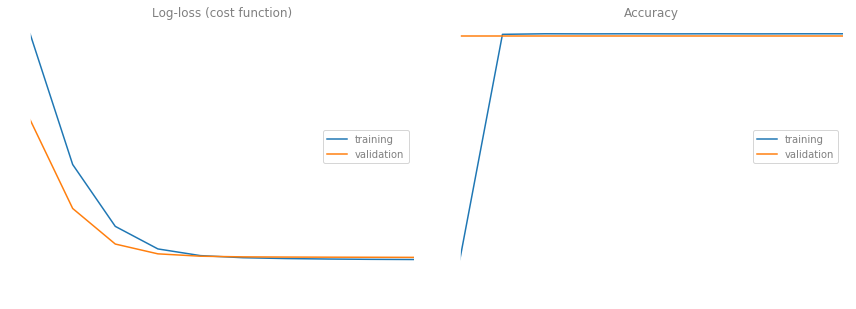

Log-loss (cost function):
training   (min:    0.022, max:    0.531, cur:    0.022)
validation (min:    0.027, max:    0.337, cur:    0.027)

Accuracy:
training   (min:    0.853, max:    0.996, cur:    0.996)
validation (min:    0.995, max:    0.995, cur:    0.995)


In [188]:
# 1 layer, 100 neurons model, with softmax (0-1 probabilities)
model = build_model(X)

model.fit(f_in(X_train), y_train, epochs=10,
    batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid),
    callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)

In [189]:
score = model.evaluate(f_in(X_valid), y_valid, verbose=1)
print("Error %.4f: " % score[0])
print("Accuracy %.4f: " % (score[1]*100))

4964/4964 [==============================] - 0s 19us/step
Error 0.0270: 
Accuracy 99.4964: 


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Accuracy is 99%!</font></h1> 

<br>
<br>
<br>
<br>

### What a better result on a Friday evening!

<br>
<br>
<br>

##### Press the PROD button?


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">2am emergency call...</font></h1> 

<br>

<img src="images/layer.jpg" style="height: 50vh">


<br>


# ...what do you mean performing terrible? We followed the instructions!



<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Time to diagnose!</font></h1> 

<br>
<br>
<br>
<br>

### We collect data visualised from production...

<br>
<br>
<br>

##### ...and label it to assess performance


In [190]:
X_prod, y_prod = get_production_dataset()

X_prod.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country
18329,0.030670,4,15,-0.031359,0,4,4,4,0,-0.145918,1.334365,-0.035429,39
997,0.690473,1,9,1.134721,0,4,4,4,1,-0.145918,-0.216656,1.422365,39
13225,-1.215625,4,15,-0.031359,2,8,0,4,1,-0.145918,-0.216656,-0.440371,39
6837,-1.142313,7,2,-0.808747,4,4,1,4,1,-0.145918,-0.216656,-0.035429,39
29132,0.837096,6,9,1.134721,2,12,0,4,1,-0.145918,-0.216656,-2.627061,39


In [191]:
score = model.evaluate(f_in(X_prod), y_prod, verbose=1)
probabilities = model.predict(f_in(X_prod))
pred = f_out(probabilities)
print("Accuracy %.4f: " % (score[1]*100))

6513/6513 [==============================] - 0s 19us/step
Accuracy 76.4932: 


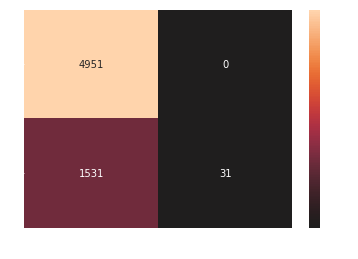

In [192]:
confusion = sklearn.metrics.confusion_matrix(y_prod, pred)
confusion_df = pd.DataFrame(confusion,
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)

0.5099231754161332


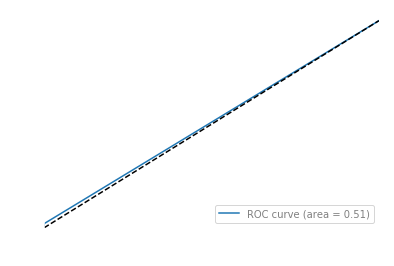

In [193]:
plot_roc(y_prod, pred)

[Text(0, 0, 'male'), Text(0, 0, 'female')]

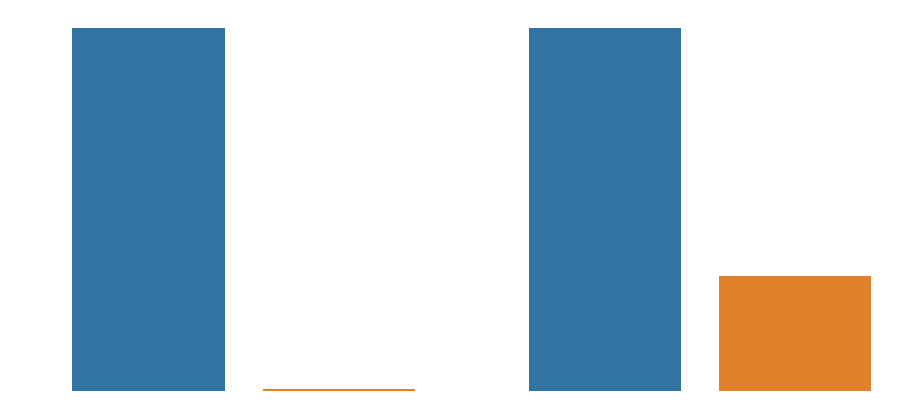

In [197]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
sn.countplot(y_valid, ax=ax[0]).set_xticklabels(["male", "female"])
sn.countplot(y_prod, ax=ax[1]).set_xticklabels(["male", "female"]) 

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Undesired bias and explainability</font></h1>

<br>
<br>

* Has become popular due to several high profile incidents:

    * Amazon's "sexist" recruitment tool
    * Microsoft's "racist" chatbot
    * Negative discrimination in automated sentencing
    * Black box models with complex patterns that can't be interpretable

<br>
<br>

## Organisations cannot take on unknown risks

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">This challenge goes beyond the algorithms</font></h1>

### A large ethical decision should not just fall on the shoulders of a single data scientist

<img src="images/chart.png" style="height:30vw;margin-left: 10vw; float: left; background-color: transparent">
<img src="images/chart-more.png" style="height:30vw; margin-left: 10vw; float: left;  background-color: transparent">


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">The answer is not just about "removing bias"</font></h1>

<br>
<br>

* Any non trivial decision (i.e. more than 1 option) holds a bias, without exceptions.
* It's impossible to "just remove bias", as the whole purpose of ML is to discriminate towards the right answer
* Societal bias carries an inherent bias - what may be "racist" for one person, may not be for another group or geography

<br>
<br>

## Let's see what "undesired bias" looks like

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Errors in scope (Bias a-priori)</font></h1>

* Sub-optimal business objectives

<br>

* Lack of understanding of the project 

<br>

* Incomplete resources (data, time, domain experts, etc)

<br>

* Incorrectly labelled data (accident vs otherwise)

<br>

* Lack of relevant skillset

<br>

* Societal shifts in perception

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Errors in project decisions (Bias a-posteriori)</font></h1>

* Sub-optimal choices of accuracy metrics / cost functions

<br>

* Sub-optimal machine learning models chosen for the task 

<br>

* Lack of infrastructure or metrics required to monitor model performance in production

<br>

* Lack of human-in-the-loop where necessary

<br>

* Not using resources at disposal (e.g. domain experts, tools, etc).

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Tackling undesired bias through tools and humans</font></h1>

<br>

## Focusing on process and best practices

* In cybersecurity it's impossible to avoid all hacking attacks, but best practices help mitigate
* Similarly, it's impossible to avoid all undesired bias, but it's possible to mitigate by having the right experts at the right touchpoints

<br>

## Using the right tools with the right domain experts

* There are numerous techniques at the disposal of data scientists to analyse datasets and evaluate models
* These should be use in conjunction with domain experts to understand explanatory/predictive modelling

<br>

## Ensure humans are leveraged

* In some use-cases the level of scrutiny is higher due to the critical nature of the project
* In those cases, the level of human review may be higher, and it may be necessary to have human-in-the-loop processes

<br>


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">How this looks in practice</font></h1>

<img src="images/mlall.png" style="width=100vw">

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Defining undesired bias through three processes</font></h1>

<br>

## Data analysis

* Class imbalances
* Protected features
* Correlations
* Data representability

<br>

## Model Analysis

* Feature importance analysis
* Model specific explainability methods
* Domain knowledge abstraction 
* Model metrics analysis


<br>

## Production monitoring

* Thresholds set for evaluation metrics 
* Manual human review on critical decisions 
* Monitoring of anomalies and out-of-range predictions


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Augmenting the data science workflow</font></h1>

<img src="images/gml.png" style="width=100vw">

# Let's see it in practice

<br>
<br>

<img src="images/xai.png" style="width=100vw">

In [261]:
# !pip install xai
import xai
print("Loaded XAI")

Loaded XAI


In [238]:
X, y, X_train, X_valid, y_train, y_valid, X_display, y_display, df, df_display \
    = get_dataset_2()
df_display.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,ethnicity,gender,capital-gain,capital-loss,hours-per-week,native-country,loan
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,False
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False


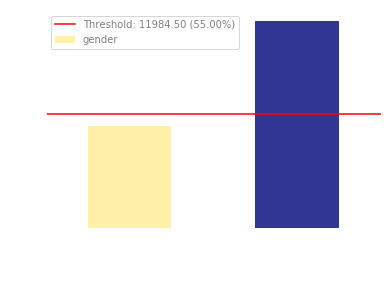

In [239]:
im = xai.show_imbalance(df_display, "gender", threshold=0.55)

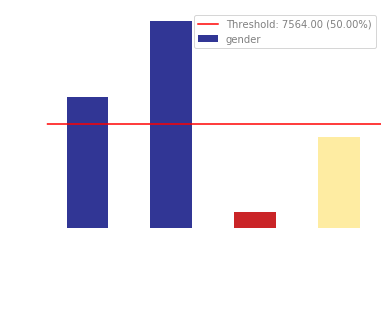

In [240]:
im = xai.show_imbalance(df_display, "gender", cross=["loan",], categorical_cols=["loan", "gender"])

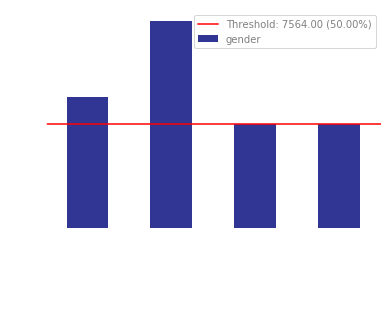

In [241]:
im = xai.balance(df_display, "gender", cross=["loan",], categorical_cols=["loan", "gender"],
                upsample=0.5)

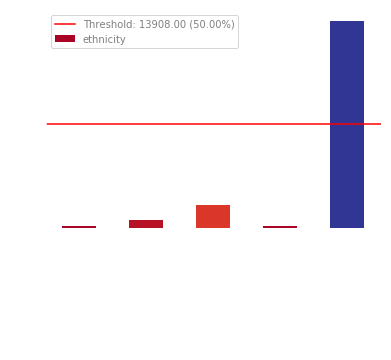

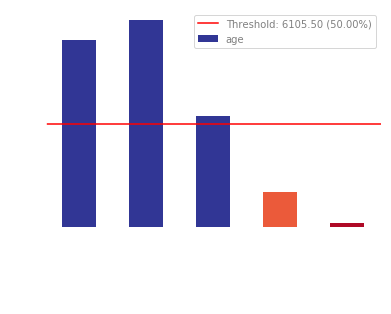

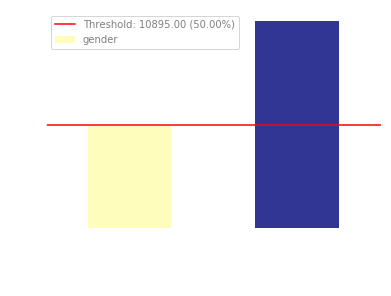

In [242]:
protected_features = ["ethnicity", "age", "gender"]
im = xai.show_imbalances(df_display, protected_features)

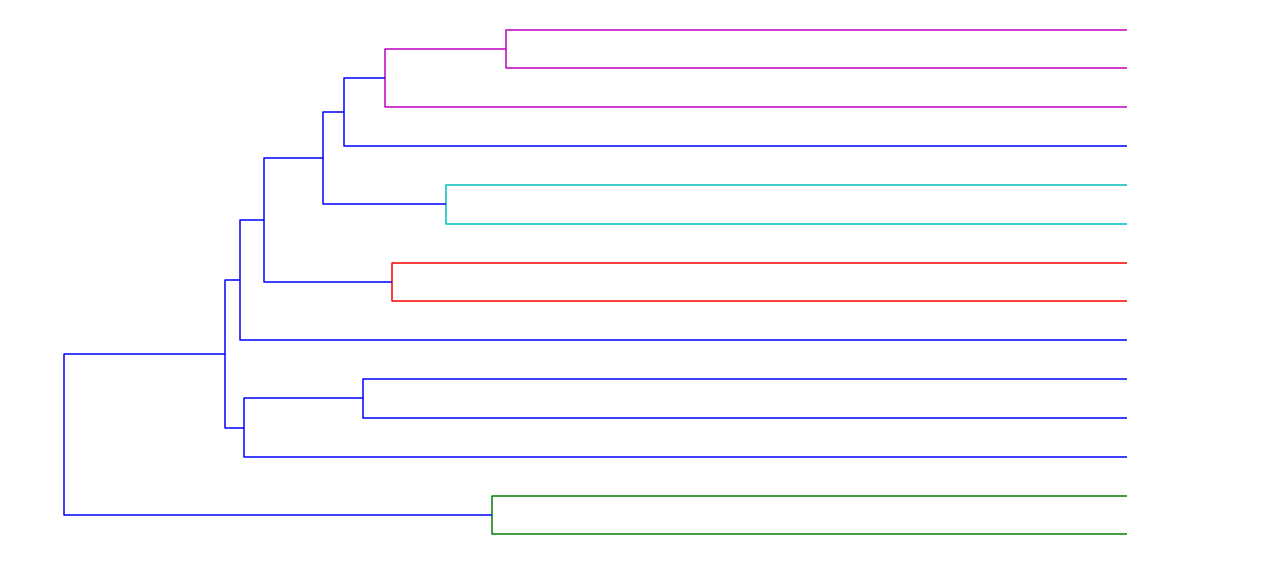

In [243]:
corr = xai.correlations(df_display, include_categorical=True, figsize=[20,10])

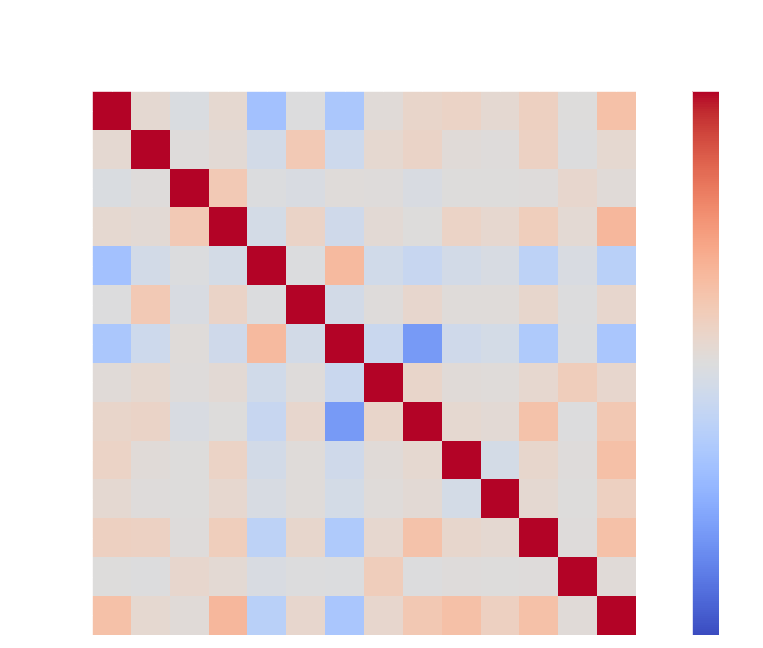

In [244]:
corr = xai.correlations(df_display, include_categorical=True, figsize=[20,10], plot_type="matrix")

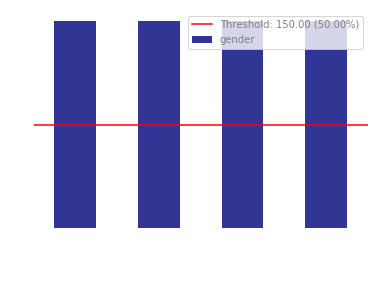

In [256]:
X_train_balanced, y_train_balanced, X_valid_balanced, y_valid_balanced = \
    xai.balanced_train_test_split(
            X, y, cross=["gender"], 
            categorical_cols=["gender", "loan"], min_per_class=300)

X_valid_balanced["loan"] = y_valid_balanced
im = xai.show_imbalance(X_valid_balanced, "gender", cross=["loan"], categorical_cols=["gender", "loan"])

# Model analysis

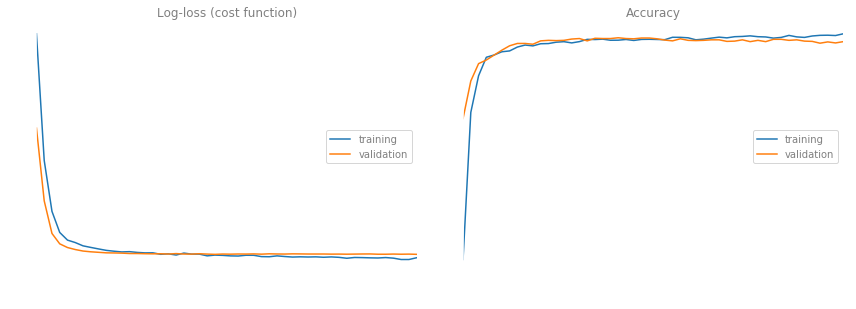

Log-loss (cost function):
training   (min:    0.305, max:    0.579, cur:    0.307)
validation (min:    0.311, max:    0.465, cur:    0.311)

Accuracy:
training   (min:    0.726, max:    0.860, cur:    0.860)
validation (min:    0.810, max:    0.858, cur:    0.855)


In [250]:
# 1 layer, 100 neurons model, with softmax
model = build_model(X)
model.fit(f_in(X_train), y_train, epochs=50, batch_size=512, shuffle=True, validation_data=(f_in(X_valid), y_valid), callbacks=[PlotLossesKeras()], verbose=0, validation_split=0.05,)
probabilities = model.predict(f_in(X_valid))
pred = f_out(probabilities)

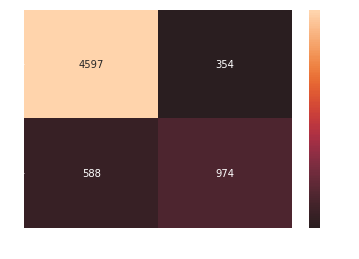

In [252]:
confusion = sklearn.metrics.confusion_matrix(y_prod, pred)
confusion_df = pd.DataFrame(confusion,
            index=["Actual Denied", "Actual Approved"], 
            columns=["Preditced Denied", "Preditced Approved"])

sn.heatmap(confusion_df, annot=True, fmt='d', center=1)

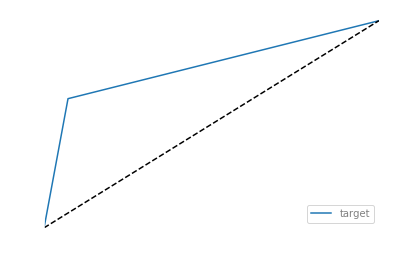

In [257]:
im = xai.roc_imbalance(X_valid, y_valid, pred)

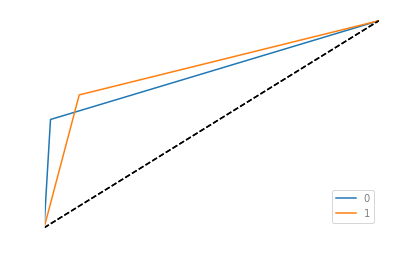

In [258]:
im = xai.roc_imbalance(X_valid, y_valid, pred, col_name="gender", categorical_cols=["gender"])

In [ ]:
im = xai.metrics_imbalance(X_valid, y_valid, pred)

In [ ]:
im = xai.metrics_imbalance(X_valid, y_valid, pred, col_name="gender", categorical_cols="gender")

In [ ]:
imp = xai.feature_importance(X_valid, y_valid, lambda x, y: model.evaluate(f_in(x), y, verbose=0)[1])

# Production  

In [ ]:
im = xai.smile_imbalance(y_valid, probabilities)

In [ ]:
im = xai.smile_imbalance(y_valid, probabilities, display_breakdown=True)

In [ ]:
im = xai.smile_imbalance(y_valid, probabilities, threshold=0.67, manual_review=0.00001)

In [ ]:
shap_explainer = shap.KernelExplainer(shap_predict, X.iloc[:100,:])
shap_idx = 0
shap_x = X.iloc[shap_idx,:]
shap_display_x = X_display.iloc[shap_idx,:]
shap_values = shap_explainer.shap_values(shap_x, nsamples=500)
shap.force_plot(shap_explainer.expected_value, shap_values, shap_display_x, matplotlib=True, figsize=(40, 3))

In [ ]:
tf_lime_explainer = LimeTabularExplainer(X_train.values,
                    feature_names=list(X_train.columns),
                    categorical_features=categorical_features)

tf_lime_explanation = tf_lime_explainer.explain_instance(
        X_train.iloc[1,:], lime_predict_proba, num_features=13) 

tf_lime_explanation.as_pyplot_figure()

In [ ]:
tf_lime_explanation.show_in_notebook(show_table=True, show_all=True)

<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Revisiting our workflow</font></h1>

<img src="images/gml.png" style="width=100vw">


<h1 style="font-size: 3em; line-height:2em;"><font style="color: white !important;">Explainability and Bias Evaluation<br> with Tensorflow</font></h1> 

<br>
<br>
<br>
<br>
<br>
<br>

<h1>Alejandro Saucedo</h1>
<br>
Chief Scientist, The Institute for Ethical AI & Machine Learning

<br>
<br>

[github.com/ethicalml/bias-analysis](github.com/ethicalml/bias-analysis)
